\setcounter{secnumdepth}{0}
\pagenumbering{gobble}
# Descrição do Trabalho

## Equipe
A equipe desse presente trabalho é composta pelo aluno Amyr Allan.

## Identificação do Trabalho
Esse presente relatório descreve a solução do segundo trabalho da disciplina de processamento de imagens. Nesse, foi pedida a gravação de um vídeo caseiro junto com a escolha de um template, com o objetivo desses serem utilizados para a realização de testes de métodos de template matching. Após a aplicação dos testes, foi socilitada a escolha do método mais adequado com base em uma métrica que deve ser elaborada pelo aluno. Por fim, foi solicitado que o método escolhido fosse utilizado para a realização do tracking do template, tendo como resultado final um vídeo.

## Instruções de Execução
### Entrada e Saída
Os arquivos de entrada (vídeos e templates) devem estar presentes na pasta inputs. Os arquivos de saída são escritos na pasta outputs. O nome dos arquivos a serem processados deve ser escrito no arquivo input_config.json, nas chaves video e template:

```json
{
    "video": "video.mp4",
    "template": "template.png"
}
```

### Execução
O código python da solução esta presente no arquivo tm.py. Para executá-lo, basta passá-lo como argumento ao interpretador python mais recente.

## Dependências
A solução descrita faz uso das seguintes bibliotecas:

* ffmpeg: para a extração dos frames
* openCV: para leitura, escrita e casamento de template
* pandas: para registro dos valores e geração dos gráficos
* matplotlib: não é usado explicitamente, mas é utilizado como backend de plotagem pelo pandas.

Para obte-las, basta utilizar o pip:

``` sh
pip install opencv-python
pip install ffmpeg-python
pip install pandas
pip install matplotlib
```

# Solução

## Descrição da Solução
Para realizar os testes, escolher um método e produzir o vídeo de tracking, realiza-se o seguinte pipeline:

* Gravação do Vídeo e Seleção do Template: é gravado o vídeo a ser utilizado nos testes. No vídeo, uma pessoa movimenta uma garrafa de água para cima, esquerda, direita e por fim a tira de cena. Naturalmente, a garrafa é escolhida como template.
* Extração de Frames: os frames individuais do vídeo são extraídos por meio de um wrapper de pyhton do software ffmpeg.
* Testes dos Métodos: os métodos são testados, registrando-se os valores mínimos e máximos da imagem resultante.
* Plotagem dos Gráficos de Valores por Frames: utilizando-se os valores mínimos e máximos registrados durante os testes, os gráficos de valores por frames de cada método são plotados.
* Seleção do Melhor Método: com base na informação fornecida pelos gráficos e uma métrica que será discutida posteriormente, o melhor método é escolhido.
* Produção do Vídeo de Tracking: utilizando-se o melhor método, é produzido o vídeo de tracking, que é salvo na pasta outputs.

## Extraindo Frames do Vídeo
Primeiramente, importa-se as bibliotecas necessárias.

In [ ]:
import cv2 as cv
import ffmpeg
import pandas
import json
import os
import shutil
import tempfile

Agora, configura-se o caminho das entradas por meio da leitura de input_config.json.

In [3]:
inputs_dir = os.path.join(os.getcwd(), 'inputs')
config_file = open("input_config.json")
config = json.load(config_file)

input_path = os.path.join(inputs_dir, config['video'])
template_path = os.path.join(inputs_dir, config['template'])

Com os caminhos obtidos, utiliza-se o opencv para abrir o vídeo de entrada, assim como para extrair metadados que serão utilizados posteriormente.

In [4]:
# Abrindo o vídeo com o openCV
src_video = cv.VideoCapture(input_path)

# Extraindo metadados do vídeo
video_w = int(src_video.get(cv.CAP_PROP_FRAME_WIDTH))
video_h = int(src_video.get(cv.CAP_PROP_FRAME_HEIGHT))
fps = src_video.get(cv.CAP_PROP_FPS)


Por fim, utiliza-se a informação do fps obtida anteriormente para a extração dos frames individuais do vídeo. Um diretório temporário é criado para armazená-los.

In [ ]:
# Criando o diretório temporário
temp_dir = tempfile.mkdtemp(dir=os.getcwd())

# Padrão de nomes de frames
frame_pattern = os.path.join(temp_dir, 'frame-%d.png')

(
    ffmpeg.input(input_path)
    .output(frame_pattern, vf=f'fps={fps}')
    .run()
)

## Realizando os Testes
Agora que os frames foram extraídos, realizam-se os testes. Durante o teste de cada método, os valores máximos, mínimos e suas respectivas coordenadas são registrados num dataframe. Esses serão utilizados posteriormente para a plotagem dos gráficos e para desenvolver o vídeo de tracking.

In [3]:
# Abrindo o template e recuperando suas dimensões
template = cv.imread(template_path, cv.IMREAD_GRAYSCALE).copy()
template_h, template_w = template.shape

# Os métodos de template matching a serem testados
tm_methods = [
    'cv.TM_CCOEFF', 
    'cv.TM_CCOEFF_NORMED',
    'cv.TM_CCORR',
    'cv.TM_CCORR_NORMED',
    'cv.TM_SQDIFF',
    'cv.TM_SQDIFF_NORMED'
]

dfs = []

for method in tm_methods:
    min_vals = []
    max_vals = []
    min_locs = []
    max_locs = []
    method = eval(method)

    for frame in os.listdir(temp_dir):
        # Lendo frame
        frame = os.path.join(temp_dir, frame)
        frame_img = cv.imread(frame, cv.IMREAD_GRAYSCALE).copy()
        
        # Executando o template matching
        result = cv.matchTemplate(frame_img, template, method)

        # Recuperando e registrando valores mínimos, máximos e sus coordenadas
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)
        min_vals.append(min_val)
        max_vals.append(max_val)
        max_locs.append(max_loc)
        min_locs.append(min_loc)

    data = {
        'min_val': min_vals,
        'max_val': max_vals,
        'min_loc': min_locs,
        'max_loc': max_locs,
    }

    dfs.append(pandas.DataFrame(data))

## Plotagem dos Gráficos
A partir dos valores obtidos anteriormente, pode-se realizar a plotagem dos gráficos de valores por frames de cada método.

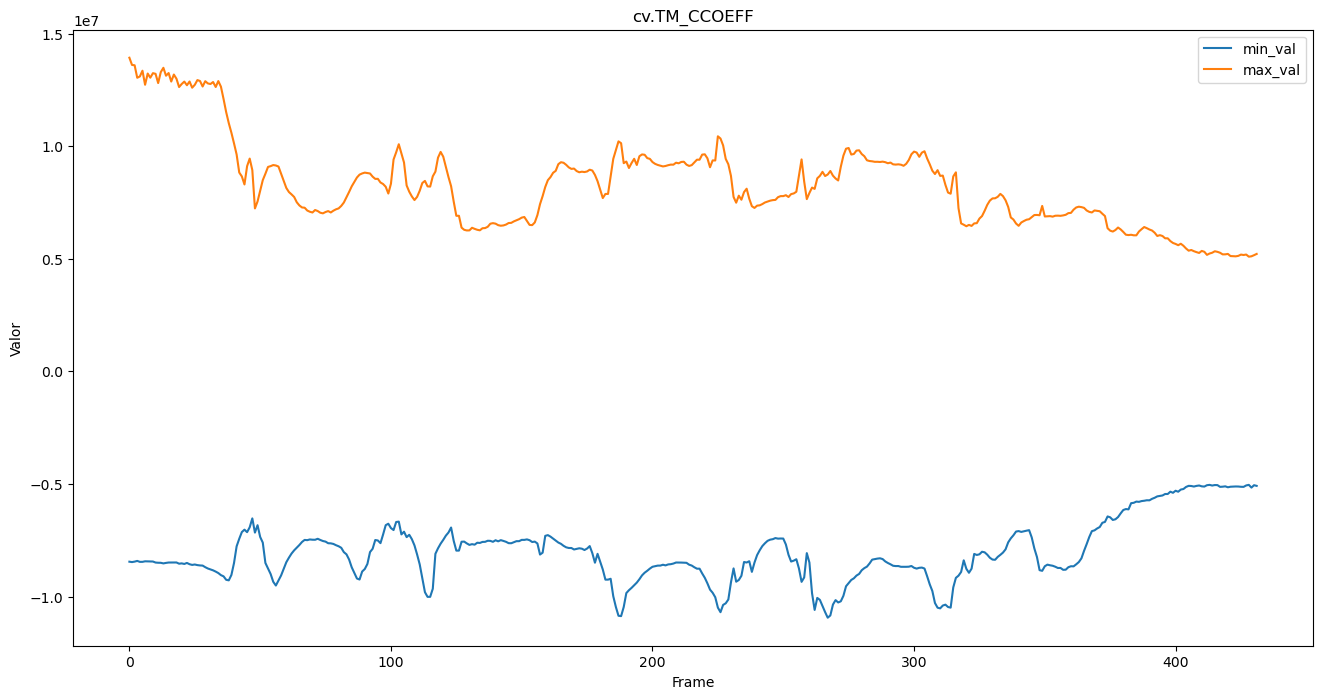

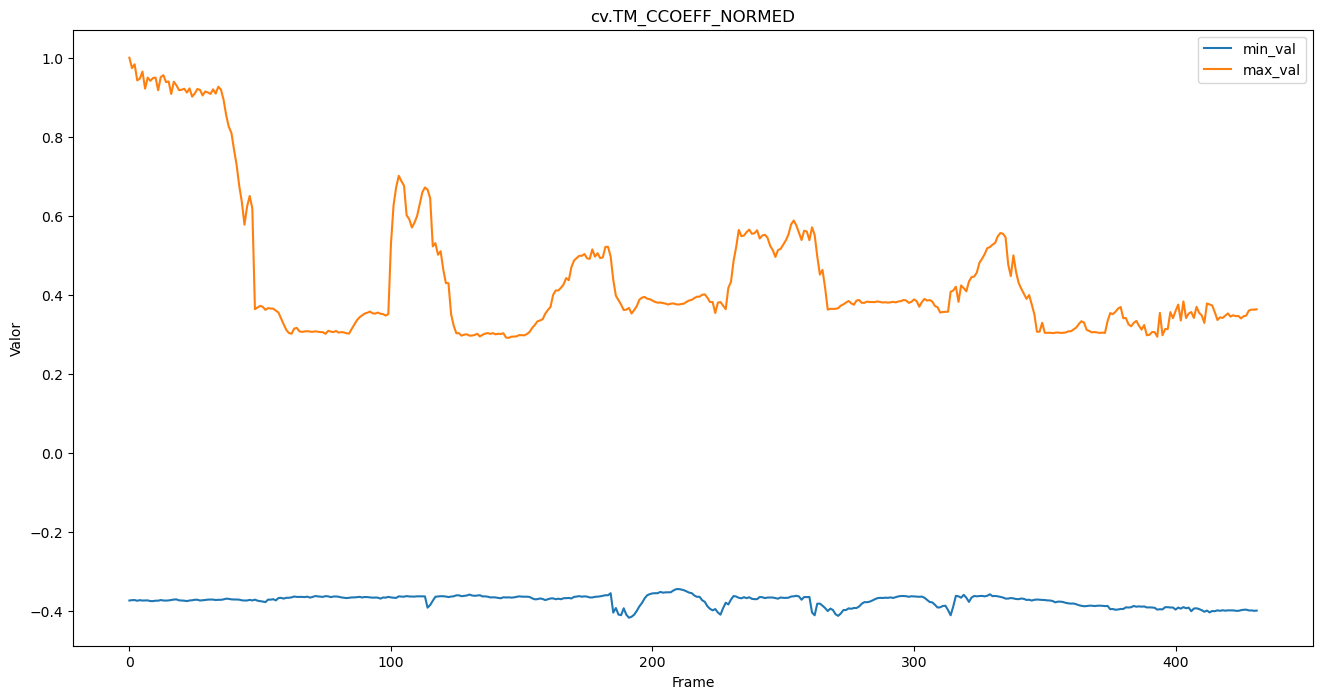

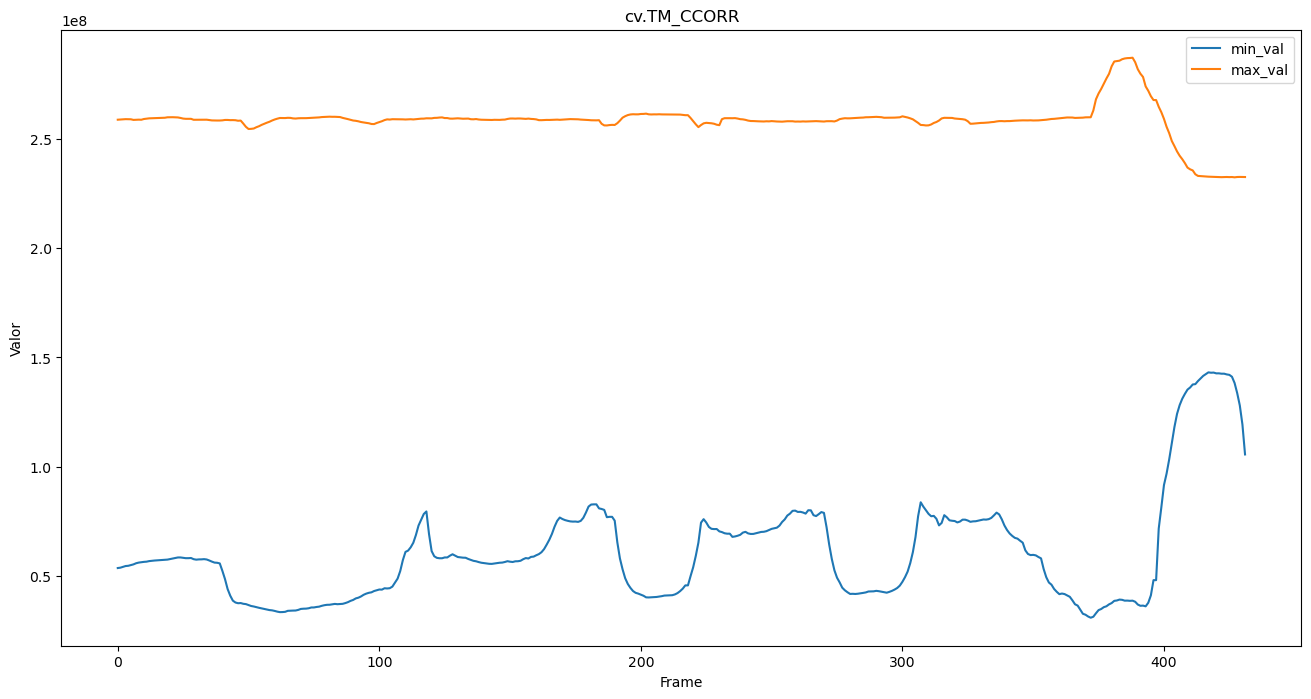

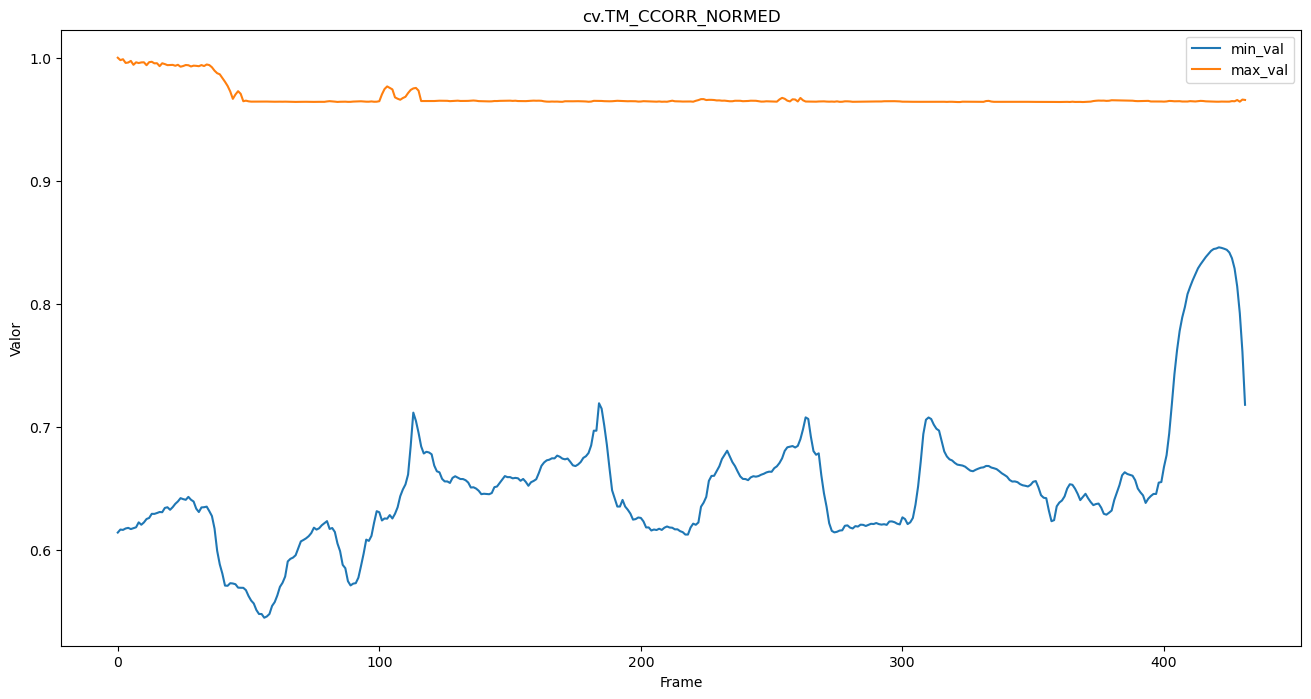

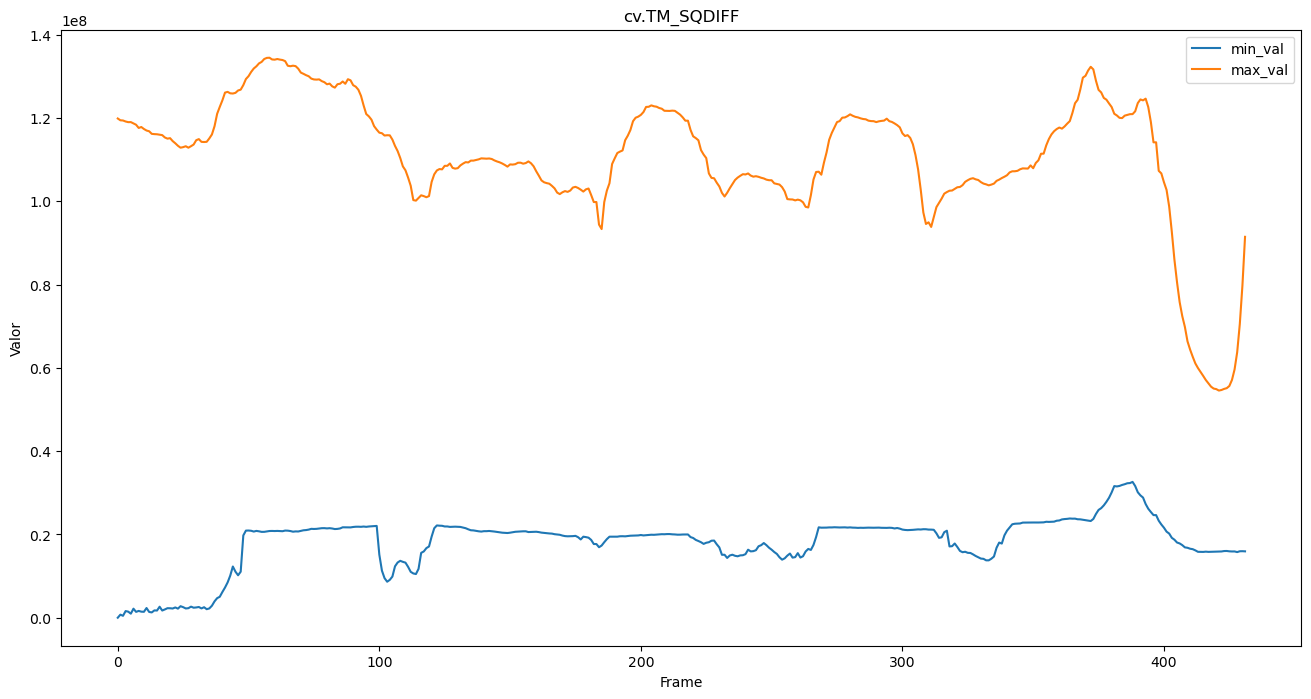

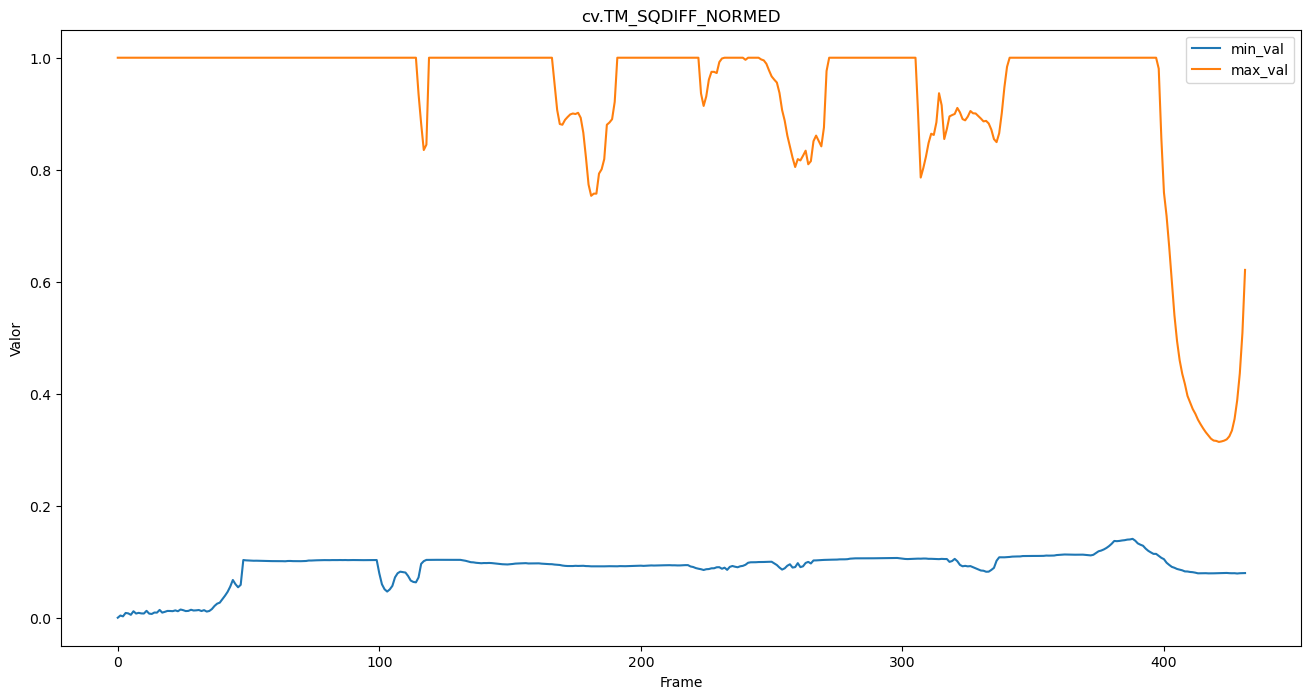

In [4]:
columns_to_plot = ['min_val', 'max_val']

for method, df in zip(tm_methods, dfs):
    df[columns_to_plot].plot(
        figsize=(16,8),
        title=method,
        xlabel='Frame',
        ylabel='Valor',
    )

## Análise dos Gráficos
Ao realizar uma analise dos gráficos, nota-se que:

* Métodos não normalizados possuem intervalos muito grandes
* Nos métodos de correlação, quando o objeto está presente no frame, podem ser notados picos nos valores máximos
* Nos métodos de diferença quadrada, quando o objeto está presente no frame, podem ser notados vales nos valores mínimos

Naturalmente, o método mais adequado é aquele que possui picos ou vales mais marcantes na presença do objeto. Através de uma inspeção visual, conclui-se que o método CCOEFF_NORM possui essas características.

## Criando o Vídeo de Tracking
Para criar o o vídeo de tracking, recupera-se os respectivos valores máximos e suas coordenadas pelo dataframe do método CCOEFF_NORM. As coordenadas desses valores são interpretados como o canto superior esquerdo do objeto de interesse na imagem. Como as dimensões do template são conhecidas, basta desenhar um retângulo com mesmas dimensões partindo das coordenadas. Para evitar que um retângulo seja desenhado em todos os frames, incluindo os que não apresentam o objeto de interesse, utiliza-se o gráfico para determinar um threshold para o valor máximo. Se o valor máximo do frame for menor que o threshold, o retângulo não é desenhado.

In [5]:
output_path = os.path.join(os.getcwd(), 'outputs', 'tracking.mp4')

codec = cv.VideoWriter_fourcc(*'mp4v')

# Objeto VideoWriter, usado para escrever os frames
out_video = cv.VideoWriter(
    output_path,
    codec,
    fps,
    (video_w, video_h),
    isColor=False
)

# Recuperando os valores máximos e suas coordenadas
max_vals = dfs[1]['max_val']
max_locs = dfs[1]['max_loc']

# Definindo threshold
tresh = 0.45

# Iterando sobre os frames, transformando-os e escrevendo-os um por um
for idx, frame in enumerate(os.listdir(temp_dir)):

    # Lendo frame
    frame = os.path.join(temp_dir, frame)
    frame_img = cv.imread(frame, cv.IMREAD_GRAYSCALE)
    
    # Desenhando um retangulo para evidenciar o objeto
    max_val = max_vals[idx]
    max_loc = max_locs[idx]

    # Escrever o frame sem transformacao
    if max_val < tresh:
        out_video.write(frame_img)

    else:
        top_left = max_loc
        bottom_right = (top_left[0] + template_w, top_left[1] + template_h)
        cv.rectangle(frame_img, top_left, bottom_right, 255, 2)
        out_video.write(frame_img)

# Fechando todos os buffers
src_video.release()
out_video.release()
cv.destroyAllWindows()

# Removendo diretório temporário
shutil.rmtree(temp_dir)

# Resultado
O vídeo resultante pode ser visualizado na pasta outputs. Nesse, uma característica interessante que pode ser observada é que o método tem dificuldade de identificar o objeto quando esse é rotacionado.